In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Set the path to the dataset
root_dir = r"C:\Users\riyad\OneDrive\Desktop\DATASETS\Rice_image"


In [4]:
image_paths = []
labels = []

# Get list of all items in the root directory
for item in os.listdir(root_dir):
    item_path = os.path.join(root_dir, item)
    if os.path.isdir(item_path):  # Check if the item is a directory
        label = item
        
        for dirpath, _, filenames in os.walk(item_path):
            for filename in filenames:
                # Construct the full path to the image
                image_path = os.path.join(dirpath, filename)
                image_paths.append(image_path)
                labels.append(label)

# Create a DataFrame from the collected paths and labels
data = {'image_path': image_paths, 'label': labels}
df = pd.DataFrame(data)

In [5]:
# checking some of the data of dataframe df
df.head()

,image_path,label
0,C:\Users\riyad\OneDrive\Desktop\DATASETS\Rice_...,Arborio
1,C:\Users\riyad\OneDrive\Desktop\DATASETS\Rice_...,Arborio
2,C:\Users\riyad\OneDrive\Desktop\DATASETS\Rice_...,Arborio
3,C:\Users\riyad\OneDrive\Desktop\DATASETS\Rice_...,Arborio
4,C:\Users\riyad\OneDrive\Desktop\DATASETS\Rice_...,Arborio


In [11]:
# converting rice label (text) to numerical label ( 0 to 4)

label_map = {'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}
df['label'] = df['label'].map(label_map)
df.head()

,image_path,label
0,C:\Users\riyad\OneDrive\Desktop\DATASETS\Rice_...,0
1,C:\Users\riyad\OneDrive\Desktop\DATASETS\Rice_...,0
2,C:\Users\riyad\OneDrive\Desktop\DATASETS\Rice_...,0
3,C:\Users\riyad\OneDrive\Desktop\DATASETS\Rice_...,0
4,C:\Users\riyad\OneDrive\Desktop\DATASETS\Rice_...,0


In [12]:
from sklearn.model_selection import train_test_split
stratify_label = df['label']

x_train, x_, y_train, y_ = train_test_split(df['image_path'], df['label'],
                                            test_size= 0.3, random_state= 42, stratify= stratify_label)

x_val, x_test, y_val, y_test = train_test_split(x_, y_, test_size= 0.5,
                                               random_state= 45, stratify= y_)

print(x_train.shape, x_val.shape, x_test.shape)

(998,) (214,) (214,)


In [13]:
# to check if split is uniform and each class in equal proportion in train, val and test set
y_test.value_counts()

label
4    88
0    80
3    26
1    13
2     7
Name: count, dtype: int64

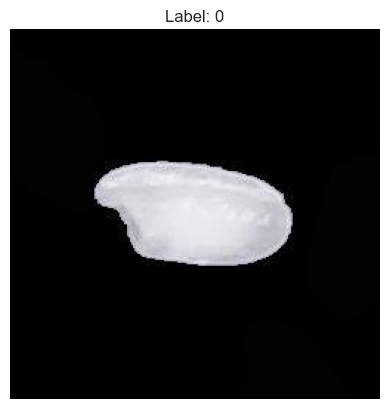

In [14]:
#Visualize a sample image¶
from PIL import Image
import matplotlib.pyplot as plt

sample_image_path = df.iloc[0]['image_path']

image = Image.open(sample_image_path)

# Display the image using matplotlib
plt.imshow(image)
plt.title(f"Label: {df.iloc[0]['label']}")
plt.axis('off')  # Hide the axis
plt.show()

In [15]:
import tensorflow as tf

def preprocess_image(image_path, image_size=(128, 128)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = image / 255.0
    return image

def data_generator(image_path, labels, image_size=(128, 128), batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((image_path, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x, image_size), y))
    dataset = dataset.shuffle(buffer_size=1024)
    batch_dataset = dataset.batch(batch_size, drop_remainder= True)
    batch_dataset = batch_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return batch_dataset

train_dataset = data_generator(x_train, y_train, image_size= (128, 128), batch_size= 32)
val_dataset = data_generator(x_val, y_val, image_size= (128, 128), batch_size= 32)
test_dataset = data_generator(x_test, y_test, image_size= (128, 128), batch_size= 32)

In [16]:
# to check images shape - 4D tensor (32, 128, 128, 3)
# 32 - batch size, 128x128 - image pixel, 3 - channels

for batch in train_dataset.take(1):
    images, labels = batch
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)

Images shape: (32, 128, 128, 3)
Labels shape: (32,)


In [17]:
#Building a CNN model 
from keras import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.losses import sparse_categorical_crossentropy

input_shape= (128,128,3)
model = Sequential([
    Conv2D(filters= 32, kernel_size= (3,3), activation= 'relu', input_shape= input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(filters= 32, kernel_size= (3,3), activation= 'relu'),
    MaxPooling2D(pool_size= (2, 2)),
    
    Flatten(),
    
    Dense(32, activation= 'relu'),
    Dense(5, activation= 'softmax')
    
    ])

# compile the model
model.compile(optimizer= 'Adam',
             loss= sparse_categorical_crossentropy,
             metrics= ['Accuracy'])

In [18]:
# Training the data for 2 epochs and using validation data as val_dataset created above

model.fit(train_dataset,
          epochs= 2,
         validation_data= val_dataset,
         )

Epoch 1/2
31/31 [==============================] - 11s 302ms/step - loss: 0.7304 - Accuracy: 0.7177 - val_loss: 0.2549 - val_Accuracy: 0.9219
Epoch 2/2
31/31 [==============================] - 9s 288ms/step - loss: 0.2128 - Accuracy: 0.9325 - val_loss: 0.3074 - val_Accuracy: 0.9115


In [19]:
# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {accuracy}")

6/6 [==============================] - 1s 71ms/step - loss: 0.3358 - Accuracy: 0.8854
Test accuracy: 0.8854166865348816


In [20]:
# Save the model
model.save('CNN_model.h5')
print ("Model saved successfully!")

Model saved successfully!
